In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from IPython.display import display, HTML
import math
from statsmodels.stats.weightstats import DescrStatsW
from matplotlib.patches import Ellipse
from sklearn.neighbors import base


## Utils

In [4]:
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)


def k_cross_validation(clf, data, target, get_classifier_mae, threshold_x=10000000, threshold_y=10000000, k=5):
    if threshold_x < 0: threshold_x = 10000000
    if threshold_y < 0: threshold_y = 10000000    
    target_pd = pd.DataFrame(target)
    
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    if not isinstance(target, np.ndarray):
        target = np.array(target)

    kf = KFold(n_splits=k, shuffle=True)
    mae_list = []
    coverage_list = [] 
    mae_list_train = []
    for train_index, test_index in kf.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]

        clf.fit(X_train, y_train)    

        stdev_xy = calculate_stdev_for_predictions(clf, X_test, target_pd)
        filter_by_std_mask = (stdev_xy[:,0] <= threshold_x) & (stdev_xy[:,1] <= threshold_y)

        coverage = sum(filter_by_std_mask)/len(filter_by_std_mask)

        y_pred = clf.predict(X_test)

        mae = get_regressor_mae(y_pred[filter_by_std_mask], y_test[filter_by_std_mask])
        mae_train = get_classifier_mae(clf.predict(X_train), y_train)
        mae_list.append(mae)
        coverage_list.append(coverage)
        mae_list_train.append(mae_train)
    return mae_list, coverage_list, mae_list_train


def calculate_stdev_for_predictions(clf, X_test, target_pd):
    neigh_dist, neigh_ind = clf.estimators_[0].kneighbors(X_test)
    weights = base._get_weights(neigh_dist, 'distance')
    stdev_x = []
    for i in range(len(X_test)):
        weighted_stats = DescrStatsW(target_pd.iloc[neigh_ind[i]][0], weights=weights[i], ddof=0)
        stdev_x.append(weighted_stats.std)

    neigh_dist, neigh_ind = clf.estimators_[1].kneighbors(X_test)
    weights = base._get_weights(neigh_dist, 'distance')
    stdev_y = []
    for i in range(len(X_test)):
        weighted_stats = DescrStatsW(target_pd.iloc[neigh_ind[i]][1], weights=weights[i], ddof=0)
        stdev_y.append(weighted_stats.std)

    stdev_x_np = np.array(stdev_x).reshape(len(stdev_x),1)
    stdev_y_np = np.array(stdev_y).reshape(len(stdev_y),1)
    stdev_xy = np.concatenate((stdev_x_np,stdev_y_np), axis=1)
    return stdev_xy

## Map utils

In [5]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]

global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111


def normalize_positions(row):
    row['x'] = row['x']-x_0
    row['y'] = row['y']-y_0
    return row


In [6]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [7]:
def group_emisions(data):
    data_dict = data.asDict()
    recep_0 = data_dict.pop('recep_0')
    recep_1 = data_dict.pop('recep_1')
    recep_2 = data_dict.pop('recep_2')
    recep_3 = data_dict.pop('recep_3')
    
    data_dict['emissions'] = []
    for i in range(24):
        data_dict['emissions'].append([recep_0[i], recep_1[i], recep_2[i], recep_3[i]])
    return data_dict


In [8]:
points_emisions = points_recep.map(group_emisions)


In [9]:
def expand_rows_with_emissions(row):
    emissions = row.pop('emissions')
    print(row)
    rows = []
    for e in emissions:
        new_row = row.copy()
        new_row['recep'] = e
        rows.append(new_row)
    return rows
        
all_emissions = points_emisions.flatMap(expand_rows_with_emissions)

### Genero los atributos y etiquetas que me interesan

In [10]:
def generate_attrs(row):
    data = {
        'antenna_0': row['recep'][0],
        'antenna_1': row['recep'][1],
        'antenna_2': row['recep'][2],
        'antenna_3': row['recep'][3],
    }
    return {'data': data, 'x': row['x'], 'y': row['y'], 'point': row['Punto']}
    
all_emissions = all_emissions.map(generate_attrs)

### Saco las emisiones sin ninguna recepcion

In [11]:
all_emissions = all_emissions.filter(lambda x: sum(x['data'].values())>0)

### Normalizo coordenadas

In [12]:
def normalize_coord(row):
    row['x'] = row['x']-x_0
    row['y'] = row['y']-y_0
    return row

all_emissions = all_emissions.map(lambda x: normalize_coord(x))

In [13]:
regre_target = pd.DataFrame(all_emissions.map(lambda x: [x['x'], x['y']]).collect())
regre_data = pd.DataFrame(all_emissions.map(lambda x: x['data']).collect())



clf = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5, weights='distance'))



def get_regressor_mae(predictions, real):
    mae = 0
    for i in range(len(predictions)):
        mae += distance(predictions[i], real[i])
    mae = mae/len(predictions)
    return mae


res_test, coverage_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae, threshold_x=-1, threshold_y=-1, k=5)
print(np.mean(res_test))
print(np.mean(coverage_test))

335.34667526386494
1.0


## Grid over stdev threshold

In [56]:
grid_res = []
threshold_list = list(np.arange(0, 350, 50)) + list(np.arange(350, 400, 10)) + list(np.arange(400, 1500, 200))
for thershold_x in threshold_list:
    for thershold_y in threshold_list:
        print('Thersholds: ({},{})'.format(thershold_x, thershold_y))
        res_test, coverage_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae, threshold_x=thershold_x, threshold_y=thershold_y, k=5)
        print('mae: {}'.format(np.mean(res_test)))
        print('coverage: {} \n'.format(np.mean(coverage_test)))
        grid_res.append([thershold_x, thershold_y, np.mean(res_test), np.mean(coverage_test)])
        
    


Thersholds: (350,350)
mae: 283.7901971124331
coverage: 0.3243342516069789 

Thersholds: (350,360)
mae: 287.6221471898614
coverage: 0.31937557392102844 

Thersholds: (350,370)
mae: 285.1523983908136
coverage: 0.3202938475665748 

Thersholds: (350,380)
mae: 291.9109318168417
coverage: 0.3263544536271809 

Thersholds: (350,390)
mae: 300.83806822025844
coverage: 0.3651056014692379 

Thersholds: (360,350)
mae: 296.6994411926431
coverage: 0.3415977961432507 

Thersholds: (360,360)
mae: 309.9064941301348
coverage: 0.359228650137741 

Thersholds: (360,370)
mae: 292.7943791177106
coverage: 0.33774104683195594 

Thersholds: (360,380)
mae: 290.7680178147042
coverage: 0.3557392102846649 

Thersholds: (360,390)
mae: 292.1156466150302
coverage: 0.36124885215794306 

Thersholds: (370,350)
mae: 291.27253457916913
coverage: 0.3392102846648301 

Thersholds: (370,360)
mae: 303.5506125029318
coverage: 0.3621671258034894 

Thersholds: (370,370)
mae: 299.4376716274205
coverage: 0.3682277318640955 

Thershol

In [62]:
grid_res_pd

,0,1,2,3
0,200,200,243.516046,0.134435
8,400,400,325.012281,0.460055
16,600,600,330.940562,0.857484
24,800,800,338.956184,0.989715
32,1000,1000,339.956265,0.999265
40,1200,1200,336.399721,1.000000
48,1400,1400,336.152975,1.000000
49,0,0,271.757985,0.069605
58,50,50,238.501575,0.076951
67,100,100,234.989668,0.087420


<IPython.core.display.Javascript object>


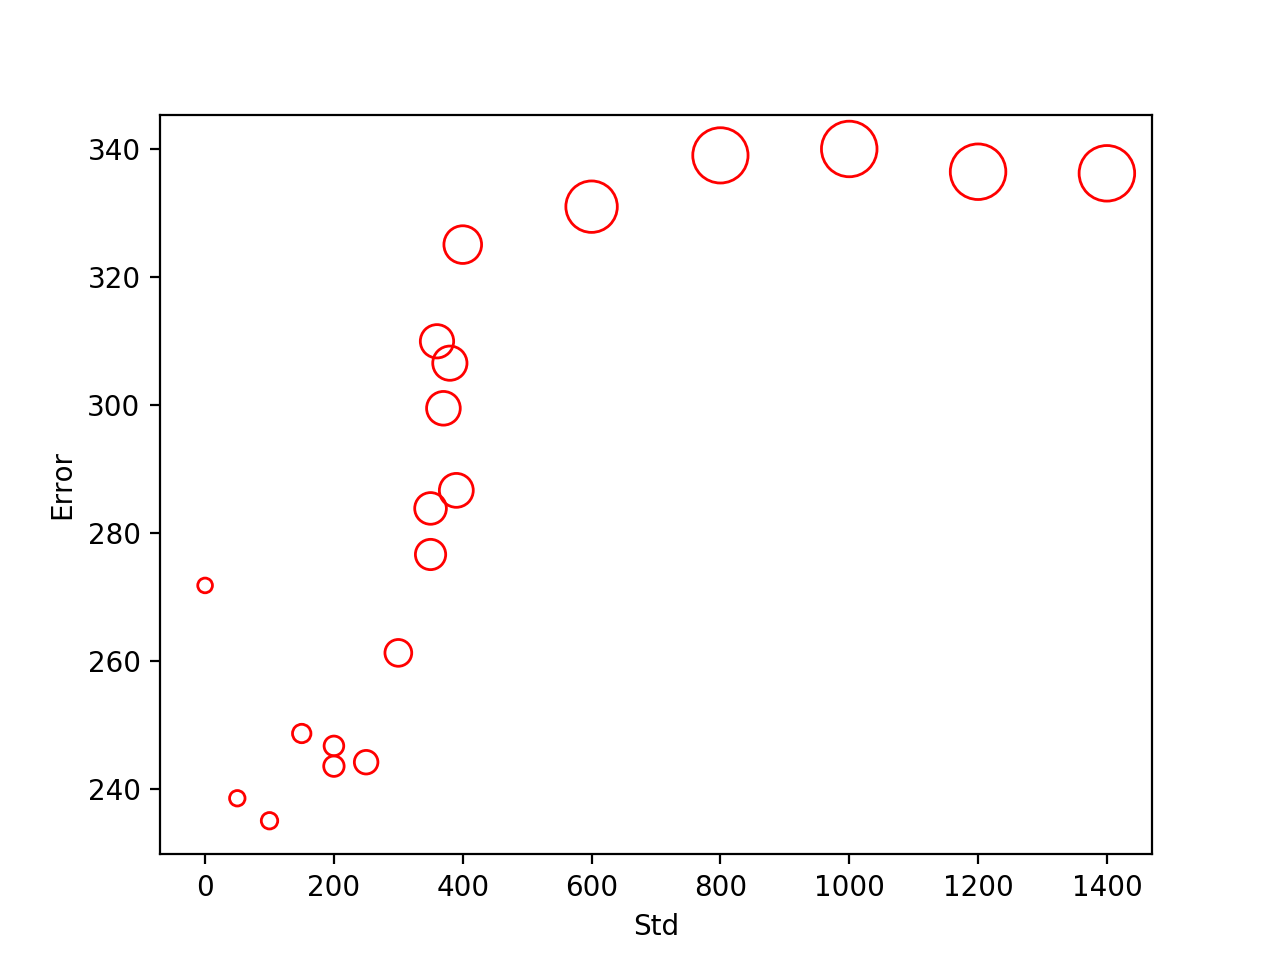

Text(0,0.5,'Error')

In [61]:
grid_res_pd = pd.DataFrame(grid_res)
## only when stdev x == stdev y
grid_res_pd = grid_res_pd[grid_res_pd[0] == grid_res_pd[1]]
fig, ax = plt.subplots()
ax.scatter(grid_res_pd[0], grid_res_pd[2], s=(grid_res_pd[3]*400).round(0), edgecolors='r', facecolors='none')
ax.set_xlabel('Std')
ax.set_ylabel('Error')


### Mapa con ejemplo de predicciones

In [136]:
def show_prediction_map_examples(predictions, real_points, stdevs):
    all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
    ax = all_points_pos.plot.scatter(x='x', y='y',c='#96EAE1')
    for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")

    plt.ylim(0,y_f-y_0)
    plt.xlim(0,x_f-x_0)

    
    for i in range(len(predictions)):
        predicted_point = predictions[i]
        real_point = real_points[i]

        if all(predicted_point == real_point):
            plt.scatter(predicted_point[0], predicted_point[1], c='g', s=15)
        else:
            
            #plt.scatter(predicted_point[0], predicted_point[1], edgecolors='r', s=15, facecolors='none')
            plt.scatter(predicted_point[0], predicted_point[1], c='r', s=15, zorder=10)
            plt.scatter(real_point[0], real_point[1], c='b', s=15, zorder=10)

            ### stdev
            circle = Ellipse((predicted_point[0], predicted_point[1]), stdevs[i][0], stdevs[i][1], fill=True)
            circle.set_edgecolor('black')
            circle.set_facecolor('#31ecff')
            ax.add_artist(circle)



            ax.arrow(real_point[0], real_point[1], predicted_point[0]-real_point[0], predicted_point[1]-real_point[1], head_width=30, head_length=30, fc='k', ec='k', length_includes_head=True, zorder=10)
            
        



<IPython.core.display.Javascript object>


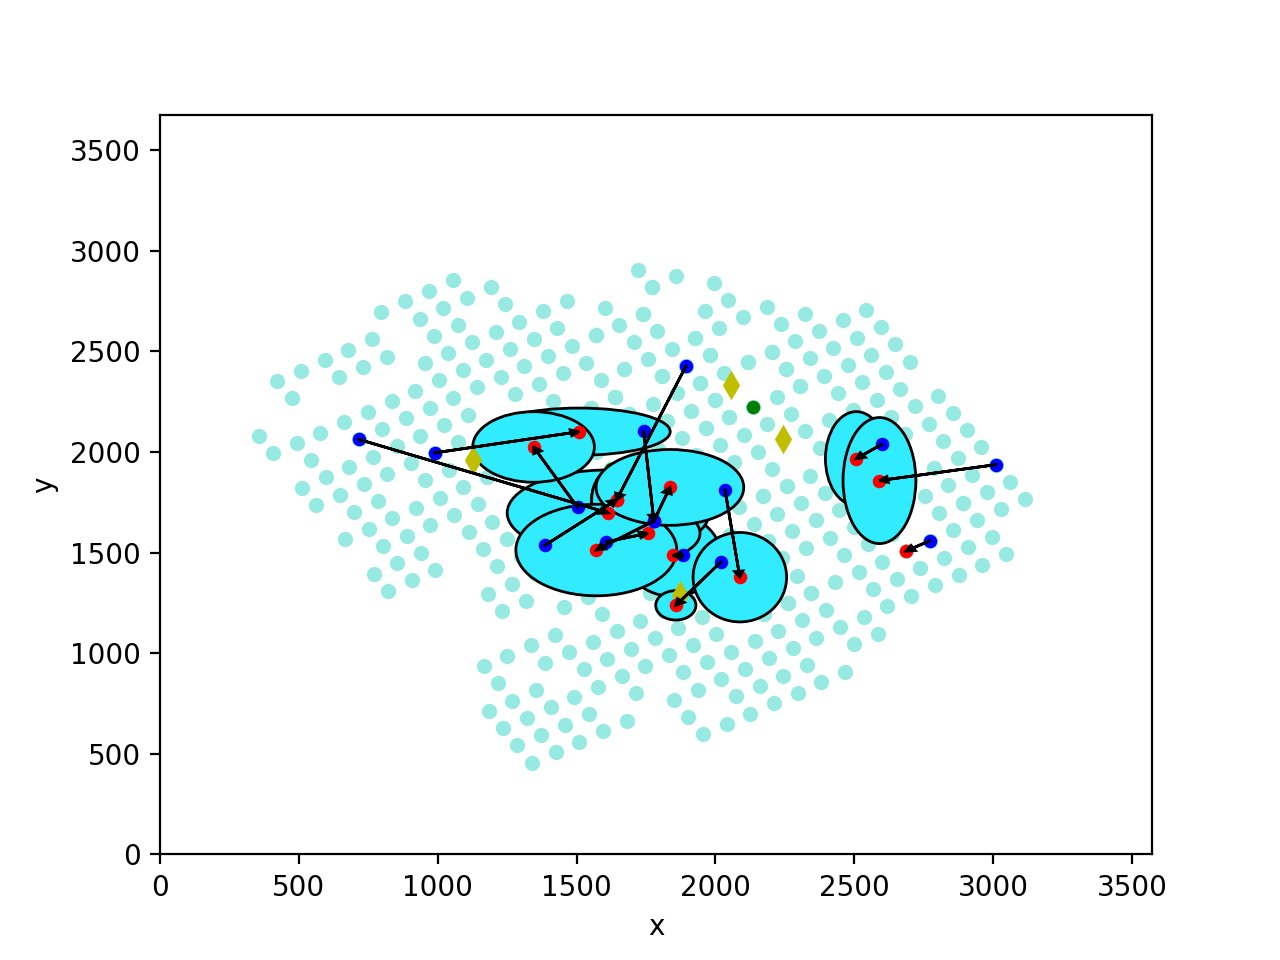

In [138]:
clf = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5, weights='distance'))
X_train, X_test, y_train, y_test = train_test_split(regre_data, regre_target, test_size=0.003)


clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
stdev_xy = calculate_stdev_for_predictions(clf, X_test, regre_target_pd)

show_prediction_map_examples(predictions, np.array(y_test), stdev_xy)